In [1]:
import sys
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch
import pickle


# Append the project dir to path
sys.path.append(os.path.join("..", "..", ".."))
from data_pipeline.utils import train_test_split, create_metadata_df, get_sample_weights_of_dataset, measurements_to_df
from data_pipeline.dataset import CARLADataset
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.dataset_xy_opt import CARLADatasetXYOpt
from data_pipeline.data_sampler import BranchPerCommandSampler
from data_pipeline.data_preprocessing import preprocessing
from models.resnet_baseline.architectures_v3 import Resnet_Baseline_V3, Resnet_Baseline_V3_Dropout
from models.resnet_baseline.architectures_v5 import Resnet_Baseline_V5
from models.resnet_lidar.lidar_v1 import Resnet_Lidar_V1
from models.model_trainer import ModelTrainer

from torch.utils.data import DataLoader
from torchvision import transforms

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# ResNet18
model_V3 = Resnet_Baseline_V3()
summary(model_V3, [(3, 88, 244), (7, ), (1,)], 64) # (3, 88, 244)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 44, 122]           9,408
       BatchNorm2d-2          [64, 64, 44, 122]             128
              ReLU-3          [64, 64, 44, 122]               0
         MaxPool2d-4           [64, 64, 22, 61]               0
            Conv2d-5           [64, 64, 22, 61]          36,864
       BatchNorm2d-6           [64, 64, 22, 61]             128
              ReLU-7           [64, 64, 22, 61]               0
            Conv2d-8           [64, 64, 22, 61]          36,864
       BatchNorm2d-9           [64, 64, 22, 61]             128
             ReLU-10           [64, 64, 22, 61]               0
       BasicBlock-11           [64, 64, 22, 61]               0
           Conv2d-12           [64, 64, 22, 61]          36,864
      BatchNorm2d-13           [64, 64, 22, 61]             128
             ReLU-14           [64, 64,

In [2]:
# ResNet34
model_V3 = Resnet_Baseline_V3()
summary(model_V3, [(3, 88, 244), (7, ), (1,)], 64) # (3, 88, 244)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 44, 122]           9,408
       BatchNorm2d-2          [64, 64, 44, 122]             128
              ReLU-3          [64, 64, 44, 122]               0
         MaxPool2d-4           [64, 64, 22, 61]               0
            Conv2d-5           [64, 64, 22, 61]          36,864
       BatchNorm2d-6           [64, 64, 22, 61]             128
              ReLU-7           [64, 64, 22, 61]               0
            Conv2d-8           [64, 64, 22, 61]          36,864
       BatchNorm2d-9           [64, 64, 22, 61]             128
             ReLU-10           [64, 64, 22, 61]               0
       BasicBlock-11           [64, 64, 22, 61]               0
           Conv2d-12           [64, 64, 22, 61]          36,864
      BatchNorm2d-13           [64, 64, 22, 61]             128
             ReLU-14           [64, 64,

In [3]:
model_lidar_V1 = Resnet_Lidar_V1()
summary(model_lidar_V1, [(3, 88, 244), (3, 161, 161), (7, ), (1,)], 64) # (3, 88, 244)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 44, 122]           9,408
       BatchNorm2d-2          [64, 64, 44, 122]             128
              ReLU-3          [64, 64, 44, 122]               0
         MaxPool2d-4           [64, 64, 22, 61]               0
            Conv2d-5           [64, 64, 22, 61]          36,864
       BatchNorm2d-6           [64, 64, 22, 61]             128
              ReLU-7           [64, 64, 22, 61]               0
            Conv2d-8           [64, 64, 22, 61]          36,864
       BatchNorm2d-9           [64, 64, 22, 61]             128
             ReLU-10           [64, 64, 22, 61]               0
       BasicBlock-11           [64, 64, 22, 61]               0
           Conv2d-12           [64, 64, 22, 61]          36,864
      BatchNorm2d-13           [64, 64, 22, 61]             128
             ReLU-14           [64, 64,

In [4]:
model_V5 = Resnet_Baseline_V5()
summary(model_V5, [(3, 88, 244), (7, ), (1,)], 64) # (3, 88, 244)

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [64, 64, 44, 122]           9,408
       BatchNorm2d-2          [64, 64, 44, 122]             128
              ReLU-3          [64, 64, 44, 122]               0
         MaxPool2d-4           [64, 64, 22, 61]               0
            Conv2d-5           [64, 64, 22, 61]          36,864
       BatchNorm2d-6           [64, 64, 22, 61]             128
              ReLU-7           [64, 64, 22, 61]               0
            Conv2d-8           [64, 64, 22, 61]          36,864
       BatchNorm2d-9           [64, 64, 22, 61]             128
             ReLU-10           [64, 64, 22, 61]               0
       BasicBlock-11           [64, 64, 22, 61]               0
           Conv2d-12           [64, 64, 22, 61]          36,864
      BatchNorm2d-13           [64, 64, 22, 61]             128
             ReLU-14           [64, 64,

In [21]:
path_data = os.path.join("..", "..", "..", "data", "data")

config = {"used_inputs": ["rgb", "lidar_bev", "measurements"], 
        "used_measurements": ["command"],    
        "seq_len": 1
        }

train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}

mean = torch.tensor([79.6657, 81.5673, 105.6161])
std = torch.tensor([66.8309, 60.1001, 66.2220])


transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

df_meta_data = create_metadata_df(path_data, config["used_inputs"])
df_meta_data_train, df_meta_data_test_1, df_meta_data_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config, df_meta_data_noisy=None)

dataset = CARLADataset(root_dir=path_data, df_meta_data=df_meta_data_train, config=config )

print(dataset.__len__())
print((dataset.__getitem__(1)['lidar_bev'].shape))

dl = DataLoader(dataset=dataset, batch_size=16, num_workers=0)

205560
(1, 641, 641)


## Preprocessing stuff

In [22]:
for batch in dl:
    break

In [50]:
from PIL import Image
import PIL
import cv2
trans = transforms.Compose([transforms.ToTensor()]) # transforms.ToPILImage(), 
img = Image.open("/Users/julianvonklitzing/Documents/GitHub/end2endappras/data/data/coke_dataset_23_11/Routes_Scenario3_Town01_curved_Seed1000/Scenario3_Town01_curved_route0_11_23_20_02_59/rgb/0000.png")
img = cv2.imread("/Users/julianvonklitzing/Documents/GitHub/end2endappras/data/data/coke_dataset_23_11/Routes_Scenario3_Town01_curved_Seed1000/Scenario3_Town01_curved_route0_11_23_20_02_59/rgb/0000.png")
img = np.array(img)
img_trans_pil = trans(img)
img_trans_cv = trans(img)

In [42]:
(np.transpose(img, (2, 0, 1)) / 255).round(4)

array([[[0.7686, 0.7686, 0.7725, ..., 0.7725, 0.7686, 0.7686],
        [0.7725, 0.7725, 0.7765, ..., 0.7686, 0.7686, 0.7686],
        [0.7725, 0.7725, 0.7765, ..., 0.7765, 0.7725, 0.7725],
        ...,
        [0.8902, 0.8863, 0.8863, ..., 0.7529, 0.5765, 0.7451],
        [0.8863, 0.8863, 0.8863, ..., 0.7451, 0.7451, 0.749 ],
        [0.8824, 0.8824, 0.8863, ..., 0.7451, 0.7451, 0.7451]],

       [[0.749 , 0.749 , 0.7529, ..., 0.7529, 0.7529, 0.749 ],
        [0.749 , 0.7529, 0.7529, ..., 0.7529, 0.7529, 0.7529],
        [0.749 , 0.7529, 0.7529, ..., 0.7529, 0.7529, 0.749 ],
        ...,
        [0.9098, 0.9098, 0.9098, ..., 0.8118, 0.7255, 0.7412],
        [0.9098, 0.9059, 0.9059, ..., 0.8118, 0.7961, 0.7961],
        [0.9059, 0.9059, 0.9059, ..., 0.8078, 0.8078, 0.8078]],

       [[0.7333, 0.7373, 0.7412, ..., 0.7412, 0.7333, 0.7333],
        [0.7333, 0.7412, 0.7412, ..., 0.7373, 0.7333, 0.7333],
        [0.7373, 0.7373, 0.7412, ..., 0.7412, 0.7412, 0.7333],
        ...,
        [0.9

In [38]:
img_trans_cv

tensor([[[0.7686, 0.7686, 0.7725,  ..., 0.7725, 0.7686, 0.7686],
         [0.7725, 0.7725, 0.7765,  ..., 0.7686, 0.7686, 0.7686],
         [0.7725, 0.7725, 0.7765,  ..., 0.7765, 0.7725, 0.7725],
         ...,
         [0.8902, 0.8863, 0.8863,  ..., 0.7529, 0.5765, 0.7451],
         [0.8863, 0.8863, 0.8863,  ..., 0.7451, 0.7451, 0.7490],
         [0.8824, 0.8824, 0.8863,  ..., 0.7451, 0.7451, 0.7451]],

        [[0.7490, 0.7490, 0.7529,  ..., 0.7529, 0.7529, 0.7490],
         [0.7490, 0.7529, 0.7529,  ..., 0.7529, 0.7529, 0.7529],
         [0.7490, 0.7529, 0.7529,  ..., 0.7529, 0.7529, 0.7490],
         ...,
         [0.9098, 0.9098, 0.9098,  ..., 0.8118, 0.7255, 0.7412],
         [0.9098, 0.9059, 0.9059,  ..., 0.8118, 0.7961, 0.7961],
         [0.9059, 0.9059, 0.9059,  ..., 0.8078, 0.8078, 0.8078]],

        [[0.7333, 0.7373, 0.7412,  ..., 0.7412, 0.7333, 0.7333],
         [0.7333, 0.7412, 0.7412,  ..., 0.7373, 0.7333, 0.7333],
         [0.7373, 0.7373, 0.7412,  ..., 0.7412, 0.7412, 0.

In [37]:
img_trans_pil

tensor([[[0.7686, 0.7686, 0.7725,  ..., 0.7725, 0.7686, 0.7686],
         [0.7725, 0.7725, 0.7765,  ..., 0.7686, 0.7686, 0.7686],
         [0.7725, 0.7725, 0.7765,  ..., 0.7765, 0.7725, 0.7725],
         ...,
         [0.8902, 0.8863, 0.8863,  ..., 0.7529, 0.5765, 0.7451],
         [0.8863, 0.8863, 0.8863,  ..., 0.7451, 0.7451, 0.7490],
         [0.8824, 0.8824, 0.8863,  ..., 0.7451, 0.7451, 0.7451]],

        [[0.7490, 0.7490, 0.7529,  ..., 0.7529, 0.7529, 0.7490],
         [0.7490, 0.7529, 0.7529,  ..., 0.7529, 0.7529, 0.7529],
         [0.7490, 0.7529, 0.7529,  ..., 0.7529, 0.7529, 0.7490],
         ...,
         [0.9098, 0.9098, 0.9098,  ..., 0.8118, 0.7255, 0.7412],
         [0.9098, 0.9059, 0.9059,  ..., 0.8118, 0.7961, 0.7961],
         [0.9059, 0.9059, 0.9059,  ..., 0.8078, 0.8078, 0.8078]],

        [[0.7333, 0.7373, 0.7412,  ..., 0.7412, 0.7333, 0.7333],
         [0.7333, 0.7412, 0.7412,  ..., 0.7373, 0.7333, 0.7333],
         [0.7373, 0.7373, 0.7412,  ..., 0.7412, 0.7412, 0.

In [34]:
img.shape

(160, 960, 3)

In [29]:
transforms.ToPILImage(batch["rgb"][0, 0])

ToPILImage(mode=tensor([[[164., 164., 166.,  ...,  28.,  22.,  38.],
         [162., 163., 167.,  ...,  34.,  59.,  71.],
         [160., 160., 167.,  ...,  64.,  81.,  77.],
         ...,
         [228., 222., 235.,  ...,  13.,  13.,  28.],
         [227., 220., 234.,  ...,  22.,  22.,  38.],
         [224., 217., 235.,  ...,  34.,  38.,  28.]],

        [[180., 180., 181.,  ...,  56.,  50.,  64.],
         [179., 180., 180.,  ...,  56.,  71.,  85.],
         [178., 179., 178.,  ...,  79.,  86.,  86.],
         ...,
         [227., 217., 225.,  ...,  22.,  22.,  38.],
         [226., 214., 223.,  ...,  28.,  34.,  34.],
         [224., 209., 223.,  ...,  46.,  38.,  28.]],

        [[191., 191., 192.,  ...,  13.,  13.,  22.],
         [190., 192., 192.,  ...,  22.,  38.,  64.],
         [191., 191., 190.,  ...,  56.,  59.,  56.],
         ...,
         [228., 209., 208.,  ...,  13.,  13.,  22.],
         [226., 206., 206.,  ...,  13.,  13.,  13.],
         [226., 199., 202.,  ...,  22

In [43]:
img = Image.open("/Users/julianvonklitzing/Documents/GitHub/end2endappras/data/data/coke_dataset_23_11/Routes_Scenario3_Town02_curved_Seed1000/Scenario3_Town02_curved_route1_11_23_20_14_06/lidar_bev/0000.png")

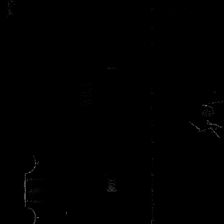

In [45]:
img.resize([224, 224])

In [52]:
img.resize([224, 224], resample=PIL.Image.BILINEAR )

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_19521/1718220959.py:1: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img.resize([224, 224], resample=PIL.Image.BILINEAR )


TypeError: 'resample' is an invalid keyword argument for this function

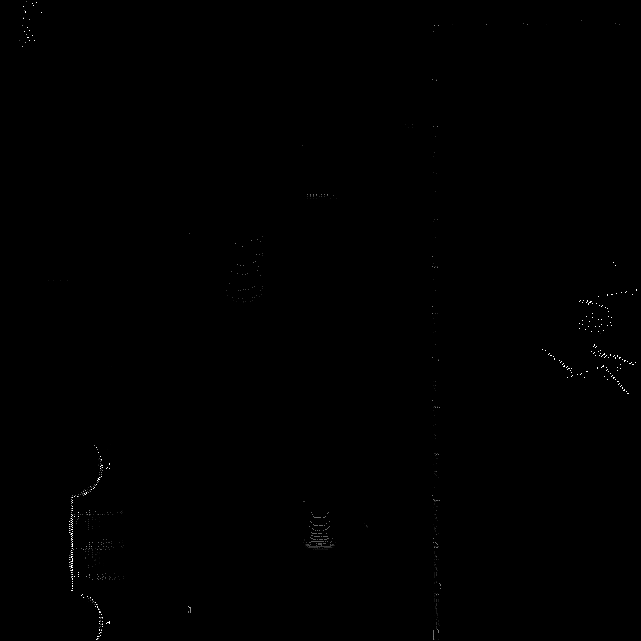

In [49]:
img